# This notebook creates a rudimentary behavioral data report.
Author: Jackie Kim

### Modules

In [32]:
# subj = 'M1008'
subj_list = ['M1005', 'M1006', 'M1007', 'M1008', 'M1011', 'M1012']

#modules for general analysis
import pprint
import numpy as np
import pandas as pd
import os
import pprint
import json
import re
#modules for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib.gridspec import GridSpec

### Functions

In [18]:
# FUNCTION TO FIND STIM SITES
def extract_stim_sites(sessions, directory_path):
    stim_sites_by_session = []

    for session in sessions:
        log_file = os.path.join(directory_path, f'session_{session}', 'elemem', 'event.log')

        # Read the log file
        try:
            with open(log_file, "r") as file:
                for line in file:
                    if '"type": "CONFIGURE"' in line:
                        try:
                            log_entry = json.loads(line.strip())
                            if "data" in log_entry and log_entry["data"]:
                                experiment = log_entry["data"].get("experiment", "N/A")
                                session_id = log_entry["data"].get("session", "N/A")
                                stim_mode = log_entry["data"].get("stim_mode", "N/A")
                                subject = log_entry["data"].get("subject", "N/A")

                                print(f'Experiment: {experiment}, Session: {session_id}, Stim Mode: {stim_mode}, Subject: {subject}')
                        except json.JSONDecodeError:
                            print(f"Error parsing JSON in {log_file}")
        except FileNotFoundError:
            print(f"Log file not found: {log_file}")
            continue
        
        # Path to the experiment.json file
        json_file = os.path.join(directory_path, f'session_{session}', 'elemem', 'experiment_config.json')
        
        # Read and parse the JSON file
        try:
            with open(json_file, "r") as file:
                data = json.load(file)
            electrodes = data.get("experiment", {}).get("stim_channels", [{}])[0].get("electrodes", "N/A")
        except (FileNotFoundError, json.JSONDecodeError):
            print(f"Error reading JSON file: {json_file}")
            electrodes = "N/A"
        
        stim_sites_by_session.append(electrodes)
        print(f'Electrodes: {electrodes}')

    return stim_sites_by_session

In [19]:
# FUNCTION that will split up the event.log (generated by elemem) into 4 task phases (encoding, math distractor, cued recall, recognition)¶
def get_rows_between_trials(df):
    # Remove rows where 'type' is 'HEARTBEAT', 'HEARTBEAT_OK', or 'ISI'
    filtered_df = df[~df['type'].isin(['HEARTBEAT', 'HEARTBEAT_OK', 'ISI', 'word stimulus info', 'start trial'])]

    # Initialize variables
    trial_start = None
    all_trial_data = []  # Initialize to an empty list
    all_dataframes = []  # List to hold DataFrames for each trial

    # Check if there's a practice list by inspecting the rows of experimentConfig type
    practice_trial_found = False

    for index, row in filtered_df.iterrows():
        # Check for 'experimentConfig' type and inspect 'data' for 'numPracticeLists'
        # numPracticeList = df.query("type == 'experimentConfig'")['data'].iloc[0]['numPracticeLists']
        practice_trial = df.query("type == 'TRIAL'")['data'].apply(lambda x: x.get('practice', False)).any()

        # Check for the start of a new trial
        if row['type'] == 'TRIAL':
            # Process the previous trial if it exists
            if trial_start is not None and all_trial_data:
                trial_data_df = pd.DataFrame(all_trial_data)

                # Subdivide the trial DataFrame into four parts
                subdivided_dfs = []

                # Finding indices for sections with safe checks
                distract_idx = trial_data_df[trial_data_df['data'].apply(lambda x: x is not None and x.get('status') == 'DISTRACT')].index
                cuedrecall_idx = trial_data_df[trial_data_df['data'].apply(lambda x: x is not None and x.get('status') == 'CUED_RECALL')].index
                recog_idx = trial_data_df[trial_data_df['type'].apply(lambda x: 'recog instructions (press any key prompt)' in x)].index
                
                # Determine the indices safely
                distract_idx = distract_idx[0] if not distract_idx.empty else len(trial_data_df)
                cuedrecall_idx = cuedrecall_idx[0] if not cuedrecall_idx.empty else len(trial_data_df)
                recog_idx = recog_idx[0] if not recog_idx.empty else len(trial_data_df)
                
                # Create the sections
                sections = {
                    "before_DISTRACT": trial_data_df.iloc[:distract_idx], # encoding
                    "between_DISTRACT_ORIENT": trial_data_df.iloc[distract_idx:cuedrecall_idx], # math distractor
                    "between_ORIENT_recog": trial_data_df.iloc[cuedrecall_idx:recog_idx], # cued recall
                    "after_recog": trial_data_df.iloc[recog_idx:]  # recognition
                }

                # Store each section DataFrame
                for key, section in sections.items():
                    subdivided_dfs.append(section.reset_index(drop=True))

                all_dataframes.append(subdivided_dfs)

            # Start a new trial
            trial_start = row
            all_trial_data = []  # Reset trial data collection
            
        # Collect data for the current trial
        all_trial_data.append(row.to_dict())  # Convert row to dict for DataFrame construction

    # Handle the last trial if needed
    if trial_start is not None and all_trial_data:
        last_trial_df = pd.DataFrame(all_trial_data)
        subdivided_dfs = []

        # Finding indices for the last trial sections
        distract_idx = last_trial_df[last_trial_df['data'].apply(lambda x: x is not None and x.get('status') == 'DISTRACT')].index
        cuedrecall_idx = last_trial_df[last_trial_df['data'].apply(lambda x: x is not None and x.get('status') == 'CUED_RECALL')].index
        recog_idx = last_trial_df[last_trial_df['type'].apply(lambda x: 'recog instructions (press any key prompt)' in x)].index
        
        distract_idx = distract_idx[0] if not distract_idx.empty else len(last_trial_df)
        cuedrecall_idx = cuedrecall_idx[0] if not cuedrecall_idx.empty else len(last_trial_df)
        recog_idx = recog_idx[0] if not recog_idx.empty else len(last_trial_df)
        
        sections = {
            "before_DISTRACT": last_trial_df.iloc[:distract_idx],
            "between_DISTRACT_ORIENT": last_trial_df.iloc[distract_idx:cuedrecall_idx],
            "between_ORIENT_recog": last_trial_df.iloc[cuedrecall_idx:recog_idx],
            "after_recog": last_trial_df.iloc[recog_idx:]  # From recog to end
        }

        for key, section in sections.items():
            subdivided_dfs.append(section.reset_index(drop=True))
        
        all_dataframes.append(subdivided_dfs)

    # If a practice trial was found, delete it from all_dataframes
    if practice_trial == True:
        print('PRACTICE FOUND')
        all_dataframes = all_dataframes[1:]  # Deleting the practice trial

    return all_dataframes

In [20]:
# FUNCTION FOR MATH DISTRACTOR
def analyze_math_distractor(dataframes, subj):
    """
    Analyzes math distractor trials across multiple sessions, summarizing correct/incorrect responses,
    and generates a bar plot for each session.

    Parameters:
        dataframes (list of lists of DataFrame): A nested list containing dataframes for each session and trial.
        subj (str): Subject identifier used for saving the figure.

    Returns:
        pd.DataFrame: A summary DataFrame containing trial-level statistics.
    """

    trial_results = []

    for session in range(len(dataframes)):
        for trial in range(len(dataframes[session])):
            # Filter DataFrame for math distractor phase where an answer is given
            filtered_df = dataframes[session][trial][1][
                dataframes[session][trial][1]['type'] == 'math distractor submit answer'
            ]

            correct_count = (filtered_df['data'].apply(lambda x: x['correct']) == True).sum()
            incorrect_count = (filtered_df['data'].apply(lambda x: x['correct']) == False).sum()

            trial_results.append({
                'Session': session,
                'Trial': trial + 1,
                'Correct': correct_count,
                'Incorrect': incorrect_count
            })

    # Create summary DataFrame
    summary_df = pd.DataFrame(trial_results)

    # Generate plots
    sessions = summary_df['Session'].unique()
    fig, axes = plt.subplots(1, len(sessions), figsize=(7 * len(sessions), 4))

    if len(sessions) == 1:
        axes = [axes]

    max_y_value = max(summary_df[['Correct', 'Incorrect']].max())

    for i, session in enumerate(sessions):
        session_df = summary_df[summary_df['Session'] == session]
        total_correct = session_df['Correct'].sum()
        total_incorrect = session_df['Incorrect'].sum()
        total_responses = total_correct + total_incorrect

        percentage_correct = (total_correct / total_responses) * 100
        percentage_incorrect = (total_incorrect / total_responses) * 100

        ax = axes[i]
        ax.bar(session_df['Trial'] - 0.2, session_df['Correct'], width=0.4, label='Correct', color='green', align='center')
        ax.bar(session_df['Trial'] + 0.2, session_df['Incorrect'], width=0.4, label='Incorrect', color='red', align='center')

        ax.set_title(f'Session {session}: Correct vs Incorrect Responses', fontsize=14)
        ax.set_xlabel('Trial', fontsize=12)
        ax.set_ylabel('Number of Responses', fontsize=12)
        ax.set_xticks(session_df['Trial'])

        ax.legend(title='Response Type')

        text_str = f'Correct: {percentage_correct:.2f}%\nIncorrect: {percentage_incorrect:.2f}%'
        ax.text(.99, 1.3, text_str, transform=ax.transAxes,
                fontsize=12, verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_ylim(0, max_y_value + 1)

    plt.tight_layout()
    plt.savefig(f"/home1/jacquelinekim/MemMap_Analyses/test/{subj}/TrialLevelMD.pdf",
                transparent=True, bbox_inches='tight', pad_inches=0.08, format='pdf')
    plt.show()

    return summary_df

In [21]:
# FUNCTION FOR PROCESSING CUED RECALL ANNOTATIONS AND CREATING A RESULTS TABLE
import pandas as pd

def process_cued_recall_data(dataframes, sessions, subj):
    """
    Processes cued recall data, extracting paired words, stimulus conditions, and expected answers.
    Reads annotation files, categorizes responses, and generates a summary table.

    Parameters:
        dataframes (list): Nested list of dataframes for each session and trial.
        sessions (list): List of session identifiers.
        subj (str): Subject identifier for file paths.

    Returns:
        pd.DataFrame: Processed cued recall DataFrame with results.
        pd.DataFrame: Summary table of cued recall performance grouped by session and stimulation condition.
    """
    
    # Initialize storage for session-level data
    temp_cr_df = [[] for _ in range(len(sessions))]

    for sess in sessions:
        print(f'Session: {sess}')
        
        cues, pairedWords, stimCond, trials_list, instances, times = [], [], [], [], [], []
        
        for trial in range(len(dataframes[sess])):
            df = dataframes[sess][trial][2]
            filtered_df = df.query("type == 'WORD'")

            for i in range(len(filtered_df)):
                current_row = filtered_df.iloc[i]
                pairedWords.append(current_row['data']['fullWord']['words'])  
                stimCond.append(current_row['data']['stimWord'])  
                trials_list.append(trial)  
                cues.append(current_row['data']['words'])  
                instances.append(i)  
                times.append(current_row['time'])

        temp_cr_df[sess] = pd.DataFrame({
            'session': sess,
            'trial': trials_list,
            'item': instances,
            'time': times,
            'stimCond': stimCond,
            'pairedWords': pairedWords,
            'cue': cues
        })

        temp_cr_df[sess]['expectedAnswer'] = temp_cr_df[sess].apply(
            lambda row: [word for word in row['pairedWords'] if word not in row['cue']], axis=1)

    temp_cr_df = pd.concat(temp_cr_df, ignore_index=True) 
    temp_cr_df['phase'] = 'CR'

    # Initialize list to store annotation data
    data = []

    # Read annotation files
    for sess in sessions:
        for trial in range(1, 13):
            for instance in range(3):
                jk_data = []
                ann_file_path = f'/home1/jacquelinekim/MemMap_Analyses/{subj}/session_{sess}/task_laptop/cuedRecall_{trial}_{instance}.ann'
                
                try:
                    with open(ann_file_path, 'r') as ann_file:
                        for line in ann_file:
                            line = line.strip()
                            if line and not line.startswith('#'):
                                items = line.split('\t')
                                jk_data.append(items)  
                except FileNotFoundError:
                    pass  

                data.append({
                    'session': sess,
                    'trial': trial-1,
                    'item': instance,
                    'data': jk_data
                })

    annotations = pd.DataFrame(data)

    # Merge annotation data with extracted cued recall data
    cr_df = pd.merge(temp_cr_df, annotations, on=['session', 'trial', 'item'], how='left')

    # Process responses
    subj_answers = [[] for _ in range(len(cr_df))]
    results = []

    for index, row in cr_df.iterrows():
        for data_entry in row['data']:
            if data_entry[2] != '<>':
                subj_answers[index].append(data_entry[2])

        if not subj_answers[index]:  
            results.append("NaN")
        elif cr_df.loc[index, 'expectedAnswer'][0] in subj_answers[index]:  
            results.append("correct")
        else:
            results.append("intrusion")

    cr_df['results'] = results  

    # Generate summary table
    stim_summary = cr_df.groupby(['session', 'stimCond'])['results'].value_counts().unstack(fill_value=0)

    # Ensure all response categories exist
    for col in ['correct', 'intrusion', 'NaN']:
        if col not in stim_summary.columns:
            stim_summary[col] = 0

    # Compute total responses per session/stim condition
    stim_summary['total'] = stim_summary.sum(axis=1)

    print('Cued Recall: Results Table')
    print(stim_summary)

    return cr_df, stim_summary


In [22]:
# FUNCTION FOR PLOTTING CUED RECALL
def plot_cued_recall_performance(cr_df, sessions, subj, stim_summary2, stimSitesBySession):
    """
    Generates multiple plots for cued recall performance analysis:
    1. Trial-level stacked bar plots per session.
    2. Stim vs. Non-Stim performance comparison.
    3. Session-level scatter overlay on mean bar chart.

    Parameters:
        cr_df (pd.DataFrame): DataFrame containing cued recall results.
        sessions (list): List of session identifiers.
        subj (str): Subject identifier for saving plots.
        stim_summary2 (pd.DataFrame): Stim vs. Non-Stim summary table.
        stimSitesBySession (list): List of stimulation sites per session.

    Returns:
        None (displays and saves plots)
    """

    # Set up the plot grid for trial-level stacked bars
    fig, axes = plt.subplots(1, len(sessions), figsize=(16, 8), sharey=True)

    if len(sessions) == 1:
        axes = [axes]

    for i, session in enumerate(sessions):
        session_df = cr_df[cr_df['session'] == session]

        # Count responses per trial
        correct_counts = session_df[session_df['results'] == 'correct'].groupby('trial').size().reset_index(name='correct')
        intrusion_counts = session_df[session_df['results'] == 'intrusion'].groupby('trial').size().reset_index(name='intrusion')
        NaN_counts = session_df[session_df['results'] == 'NaN'].groupby('trial').size().reset_index(name='NaN')

        # Merge counts
        merged_data = pd.DataFrame({'trial': session_df['trial'].unique()})
        merged_data = pd.merge(merged_data, correct_counts, on='trial', how='left').fillna(0)
        merged_data = pd.merge(merged_data, intrusion_counts, on='trial', how='left').fillna(0)
        merged_data = pd.merge(merged_data, NaN_counts, on='trial', how='left').fillna(0)
        merged_data[['correct', 'intrusion', 'NaN']] = merged_data[['correct', 'intrusion', 'NaN']].astype(int)

        # Compute percentages
        total_responses = merged_data[['correct', 'intrusion', 'NaN']].sum().sum()
        correct_percentage = (merged_data['correct'].sum() / total_responses) * 100
        intrusion_percentage = (merged_data['intrusion'].sum() / total_responses) * 100
        NaN_percentage = (merged_data['NaN'].sum() / total_responses) * 100

        # Plot stacked bars
        ax = axes[i]
        ax.bar(merged_data['trial'] + 1, merged_data['correct'], color='#440154', label='Correct')
        ax.bar(merged_data['trial'] + 1, merged_data['intrusion'], bottom=merged_data['correct'], color='#20908d', label='Intrusion')
        ax.bar(merged_data['trial'] + 1, merged_data['NaN'], bottom=merged_data['correct'] + merged_data['intrusion'], color='grey', label='NaN')

        ax.set_title(f'Session {session}', fontsize=12)
        ax.set_xlabel('Trial', fontsize=10)
        ax.set_xticks(merged_data['trial'] + 1)

        if i == 0:
            ax.set_ylabel('Item Count', fontsize=10)
            ax.legend(title='Score', loc='upper left')

        # Add percentage summary text
        textstr = f"Correct: {correct_percentage:.2f}%\nIntrusion: {intrusion_percentage:.2f}%\nNaN: {NaN_percentage:.2f}%"
        ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top',
                horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    fig.suptitle('Cued Recall Performance by Trial (Stacked)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f"/home1/jacquelinekim/MemMap_Analyses/test/{subj}/TrialLevelCR_Stacked_by_Session.pdf",
                transparent=True, bbox_inches='tight', pad_inches=0.08, format='pdf')
    plt.show()

    ### **Stim vs. Non-Stim Comparison** ###
    stim_summary = cr_df.groupby('stimCond')['results'].value_counts().unstack(fill_value=0)
    for col in ['correct', 'intrusion', 'NaN']:
        if col not in stim_summary.columns:
            stim_summary[col] = 0

    stim_summary['total'] = stim_summary.sum(axis=1)
    stim_summary[['correct_pct', 'intrusion_pct', 'NaN_pct']] = (stim_summary[['correct', 'intrusion', 'NaN']] / stim_summary['total']) * 100

    # Create comparison plot
    fig, ax = plt.subplots(figsize=(6, 6))
    x_labels = ['No Stim', 'Stim']
    x_positions = np.arange(len(x_labels))

    for i, stim_cond in enumerate([False, True]):
        ax.bar(x_positions[i], stim_summary.loc[stim_cond, 'correct_pct'], color='#440154')
        ax.bar(x_positions[i], stim_summary.loc[stim_cond, 'intrusion_pct'], bottom=stim_summary.loc[stim_cond, 'correct_pct'], color='#20908d')
        ax.bar(x_positions[i], stim_summary.loc[stim_cond, 'NaN_pct'], bottom=stim_summary.loc[stim_cond, 'correct_pct'] + stim_summary.loc[stim_cond, 'intrusion_pct'], color='grey')

    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel('Percentage of Responses', fontsize=12)
    ax.set_title('Cued Recall Performance: Stim vs. Non-Stim', fontsize=14)
    ax.legend(title='Response Type', loc='upper left')

    plt.tight_layout()
    plt.savefig(f"/home1/jacquelinekim/MemMap_Analyses/test/{subj}/OverallCR_Stacked_Stim_vs_NonStim.pdf",
                transparent=True, bbox_inches='tight', pad_inches=0.08, format='pdf')
    plt.show()

    ### **Session-Level Scatter Overlay** ###
    session_colors = sns.color_palette("Set2", n_colors=len(stim_summary2.index.levels[0]))

    stim_summary_pct = stim_summary2.copy()
    stim_summary_pct.iloc[:, :-1] = stim_summary_pct.iloc[:, :-1].div(stim_summary_pct["total"], axis=0) * 100
    stim_summary_pct.drop(columns=["total"], inplace=True)
    stim_mean_pct = stim_summary_pct.groupby("stimCond").mean()[["correct", "intrusion", "NaN"]].T

    fig, ax = plt.subplots(figsize=(9, 6))
    ax = stim_mean_pct.plot(kind="bar", figsize=(9, 6), width=0.7, alpha=0.7, edgecolor="black", color=["black", "royalblue"], legend=True)

    legend_labels = {}
    for session_idx, session in enumerate(stim_summary2.index.levels[0]):
        color = session_colors[session_idx]
        session_label = f"Session {session}: {stimSitesBySession[session_idx]}"
        session_data = stim_summary_pct.loc[session]
        for i, stim_cond in enumerate([False, True]):
            session_points = session_data[session_data.index.get_level_values("stimCond") == stim_cond]
            for j, category in enumerate(["correct", "intrusion", "NaN"]):
                x_positions = [j + (-0.15 if i == 0 else 0.15)] * len(session_points)
                y_values = session_points[category]
                ax.scatter(x_positions, y_values, color=color, marker="o", label=session_label if session_label not in legend_labels else "")
                legend_labels[session_label] = color

    ax.set_title("Cued Recall Performance", fontsize=16)
    ax.set_ylabel("Percentage (%)", fontsize=15)
    ax.set_xlabel("Category", fontsize=15)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=8) for color in legend_labels.values()]
    ax.legend(handles, legend_labels.keys(), title="Session", loc="upper right")

    plt.show()

### Code running through all subjects

In [33]:
all_subject_dfs = []

for ind, subj in enumerate(subj_list):
    # Define and filter session folders
    directory_path = '/home1/jacquelinekim/MemMap_Analyses/' + str(subj) + '/'
    folder_names = os.listdir(directory_path)
    sessions = [int(folder.split('_')[1]) for folder in folder_names if folder.startswith('session_')]
    # Sort and print
    sessions.sort()
    print('Subject: ' + str(subj)) 
    print(sessions)
    
    stim_sites_by_session = extract_stim_sites(sessions, directory_path) # Find stim sites using function
    
    dataframes = [[] for _ in range(len(sessions))] #setting up the dataframe structure by session. noting which sessions have practice sessions.
    raw_log = {}
    for sess in sessions:
        print('session ' + str(sess) + ':')
        path = f'/home1/jacquelinekim/MemMap_Analyses/{subj}/session_{sess}/elemem/event.log'
        raw_log[sess] = pd.read_json(path, lines=True)
        dataframes[sess] = get_rows_between_trials(raw_log[sess]) # Apply the function
        
        
        
        
    temp_enc_cr_df = [[] for _ in range(len(sessions))]

    for sess in sessions:
        print('session: ' + str(sess))
        rows = []

        for trial in list(range(len(dataframes[sess]))):
            cr_df = dataframes[sess][trial][2]
            enc_df = dataframes[sess][trial][0]

            # Filter rows for 'WORD'
            filtered_cr = cr_df.query("type == 'WORD'")
            filtered_enc = enc_df.query("type == 'WORD'")


            for item_idx, (i, current_row) in enumerate(filtered_cr.iterrows()):
                rows.append({
                    'subject': subj,
                    'session': sess,
                    'trial': trial,
                    'item': item_idx,
                    'phase': 'CUEDRECALL',
                    'time': current_row['time'],
                    'stimEnc': 999,
                    'stimCR': current_row['data']['stimWord'],
                    'pairedWords': current_row['data']['fullWord']['words'],
                    'cue': current_row['data']['words']
                })
            for item_idx, (i, current_row) in enumerate(filtered_enc.iterrows()):
                rows.append({
                    'subject': subj,
                    'session': sess,
                    'trial': trial,
                    'item': item_idx,
                    'phase': 'ENCODING',
                    'time': current_row['time'],
                    'stimEnc': current_row['data']['stimWord'],
                    'stimCR': 999,
                    'pairedWords': 999,  # or fill as needed
                    'cue': 999
                })
                    
            # Add 'expectedAnswer' column by selecting the word in 'pairedWords' not in 'cue'
            temp_enc_cr_df[sess] = pd.DataFrame(rows) #assign dataframe
            
            temp_enc_cr_df[sess]['expectedAnswer'] = temp_enc_cr_df[sess].apply(
                lambda row: (
                    [word for word in row['pairedWords'] if word not in row['cue']]
                    if isinstance(row['pairedWords'], list) and isinstance(row['cue'], list)
                    else 999
                ),
                axis=1
            )
    temp_enc_cr_df = pd.concat(temp_enc_cr_df, ignore_index=True) #combine session dataframes into 1 dataframe per subject
    temp_enc_cr_df['stim_pair'] = stim_sites_by_session[sess]
    
    data = []

    # Loop through trials and instances to read the data
    for sess in sessions:
        for trial in range(1, 13):
            for instance in range(3):
                # Prepare the row for the DataFrame

                # Read JK data
                jk_data = []
                ann_file_path = f'/home1/jacquelinekim/MemMap_Analyses/{subj}/session_{sess}/task_laptop/cuedRecall_{trial}_{instance}.ann'
                with open(ann_file_path, 'r') as ann_file:
                    for line in ann_file:
                        line = line.strip()
                        if line and not line.startswith('#'):
                            items = line.split('\t')
                            jk_data.append(items)  # Keep as list of lists

                # Append the data for this trial and instance
                data.append({
                    'session': sess,
                    'trial': trial-1,
                    'item': instance,
                    'data': jk_data})

    # Create a DataFrame
    annotations = pd.DataFrame(data)

    # Merge
    cr_df = pd.merge(temp_enc_cr_df, annotations, on=['session', 'trial', 'item'], how ='left')
    cr_df.loc[cr_df['phase'] != 'CUEDRECALL', 'data'] = 999
    
    
    
    # Generating a Results Column
    subj_answers = [[] for _ in range(len(cr_df))]
    results = []

    
    for index, row in cr_df.iterrows():
        data_field = row['data']
        # Default result for non-iterable rows
        result_value = 999
        if isinstance(data_field, list):  # CUEDRECALL rows
            subj_answers[index] = [entry[2] for entry in data_field if entry[2] != '<>']

            if len(subj_answers[index]) == 0:
                result_value = 'verbalization' 
            elif cr_df.loc[index, 'expectedAnswer'][0] in subj_answers[index]:
                result_value = 'correct'    # Correct
            else:
                result_value = 'intrusion'    # Intrusion
        results.append(result_value)

    # Assign new column
    cr_df['results'] = results

    
    
    
    # Initialize the session DataFrame for each session (empty at the start)
    recog_df = [[] for _ in range(len(sessions))]

    for session in sessions:
        print('session: ' + str(session))

        # Initialize an empty list to store data for all trials in the current session
        session_recogAnswers = []
        session_pairedWords = []
        session_cue = []
        session_trials_list = []
        session_item_idx = []
        session_recogStimCond = []
        session_encStimCond = []
        session_times = []
        
        response_times = []
        last_word_time = None  # Track last WORD time

        for trial in list(range(len(dataframes[session]))):

            # Filter rows for 'WORD' and 'old new keys'
            filtered_recog = dataframes[session][trial][3].query("type == 'WORD' | type == 'old new keys'")
            filtered_recog = filtered_recog.copy()
            # Assign item indices (0–5) to WORD rows only
            word_mask = filtered_recog['type'] == 'WORD'
            filtered_recog.loc[word_mask, 'item'] = range(word_mask.sum())
            
            filtered_enc = dataframes[session][trial][0].query("type == 'WORD'")

            for i in range(len(filtered_recog)):
                current_row = filtered_recog.iloc[i]

                if current_row['type'] == 'WORD':
                    session_times.append(filtered_recog.iloc[i]['time'])
                    session_trials_list.append(trial)  # Add the trial number to the list
                    session_recogStimCond.append(current_row['data']['stimWord']) # Add stim condition
                    session_pairedWords.append(current_row['data']['fullWord']['words'])  # Add paired words
                    session_cue.append(current_row['data']['words'])
                    session_item_idx.append(int(current_row['item']))
                    
                    if len([w for w in current_row['data']['fullWord']['words'] if w.strip() != '']) == 2:
                        #looking for the row in encoding when the old pair of words was presented
                        target_words = set(current_row['data']['fullWord']['words'])
                        target_row = filtered_enc[filtered_enc['data'].apply(lambda x: set(x['words']) == target_words)]
                        #find if encoding stim
                        enc_stim = target_row.iloc[0]['data']['stimWord'] if not row.empty else 999
                        
                        session_encStimCond.append(enc_stim)
                    else: #if new word
                        session_encStimCond.append(999)

                    # Check if the next row is an 'old new keys' row
                    if i + 1 < len(filtered_recog) and filtered_recog.iloc[i + 1]['type'] == 'old new keys':
                        session_recogAnswers.append(filtered_recog.iloc[i + 1]['data']['old new'])  # Add recognition answer from 'old new keys'
                        next_row = filtered_recog.iloc[i + 1]
                        rt = next_row['time'] - current_row['time']
                        response_times.append(rt)
                    else:
                        session_recogAnswers.append(999)  # No 'old new keys' after this 'WORD'
                        response_times.append(None)
    

        # Now, add the collected data for all trials into the session DataFrame
        recog_df[session] = pd.DataFrame({
            'subject': subj,
            'session': session,
            'trial': session_trials_list,  
            'item': session_item_idx,
            'time': session_times,
            'stim_pair': stim_sites_by_session[sess],
            'stimEnc': session_encStimCond,
            'stimRec': session_recogStimCond,
            'pairedWords': session_pairedWords,
            'cue': session_cue,
            'subjAnswer': session_recogAnswers,
            'response_time': response_times,
        })

        # Add 'expectedAnswer' column based on the length of the pairedWords list
        recog_df[session]['expectedAnswer'] = recog_df[session]['pairedWords'].apply(
            lambda x: 'old' if len([word for word in x if word]) == 2 else 'new'
        )

    recog_df = pd.concat(recog_df, ignore_index=True) #combine session dataframes into 1 dataframe
    recog_df['phase'] = 'RECOGNITION'
    
    
    # Reorder the DataFrame
    cols = list(recog_df.columns)
    cols.remove('expectedAnswer') # Move 'answerKey' before 'subjAnswer'
    index = cols.index('subjAnswer')
    cols.insert(index, 'expectedAnswer')
    recog_df = recog_df[cols]
    
    
    # Creating a new column 'Response Type'
    conditions = [ # Define conditions
        (recog_df['subjAnswer'] == 'old') & (recog_df['expectedAnswer'] == 'old'),  # Hit
        (recog_df['subjAnswer'] == 'new') & (recog_df['expectedAnswer'] == 'new'),  # Correct Rejection
        (recog_df['subjAnswer'] == 'new') & (recog_df['expectedAnswer'] == 'old'),  # False Alarm
        (recog_df['subjAnswer'] == 'old') & (recog_df['expectedAnswer'] == 'new'),  # Miss
    ]
    choices = ['hit', 'correct_rejection', 'false_alarm', 'miss'] # Define corresponding choices
    recog_df['Response Type'] = np.select(conditions, choices, default=999)  # Apply conditions

    
    
    # Replacing NaNs in Enc Stim with the stim condition for other items in that session and trial
    def fill_encstim_by_group(df):
        # Create a copy to avoid modifying the original DataFrame
        df = df.copy()

        # Group by session and trial
        grouped = df.groupby(['session', 'trial'])

        for (sess, trial), group in grouped:
            # Get the first non-null EncStim value (True/False)
            non_nan_value = group['stimEnc'].dropna().unique()

            # Only fill if there's exactly one non-NaN value (i.e., not mixed True/False)
            if len(non_nan_value) == 1:
                df.loc[group.index, 'stimEnc'] = df.loc[group.index, 'stimEnc'].fillna(non_nan_value[0])
        return df

    # Apply the function
    recog_df = fill_encstim_by_group(recog_df)
    
#     # Function to determine Stim Condition
#     def stim_condition(row):
#         if row['stimEnc'] == True:
#             return 'Enc Stim'
#         elif row['stimRec'] == True:
#             return 'Recog Stim'
#         else:
#             return 'No Stim'

#     # Applying function to create the 'Stim Condition' column
#     recog_df['Stim Condition'] = recog_df.apply(stim_condition, axis=1)
    
    
    
    
#     ##### looking only at recognized trials
#     recognizedWords = recog_df[(recog_df['answerKey'] == 'old') & 
#                (recog_df['Response Type'].isin(['Hit']))]
#     # Convert pairedWords in recognizedWords to sets
#     recognized_sets = recognizedWords['pairedWords'].apply(lambda x: set(x))
#     # Create a set of frozensets for fast lookup (frozensets are hashable)
#     recognized_set = set(frozenset(pair) for pair in recognized_sets)
#     # Filter cr_df where pairedWords match any in recognized_set
#     cr_df_filtered = cr_df[cr_df['pairedWords'].apply(lambda x: frozenset(x) in recognized_set)]
     
        
    
    
#     # Group by session and stimCond, then count occurrences of each result type
#     stim_summary_filtered = cr_df_filtered.groupby(['subject', 'session', 'stimEnc', 'stimCR'])['results'].value_counts().unstack(fill_value=0)
#     # Ensure all response categories exist
#     for col in ['Correct', 'Intrusion', 'NaN']:
#         if col not in stim_summary_filtered.columns:
#             stim_summary_filtered[col] = 0
#     # Summing across conditions
#     stim_summary_filtered['total'] = stim_summary_filtered.sum(axis=1)

    
    
    
#     # GENERAL FORMATTING
#     df_vertical_filtered = stim_summary_filtered.reset_index()
#     conditions = [ # Define conditions
#         (df_vertical_filtered["stimEnc"] == False) & (df_vertical_filtered["stimCR"] == False),
#         (df_vertical_filtered["stimEnc"] == True),
#         (df_vertical_filtered["stimCR"] == True)]
#     values = ["No Stim", "Enc Stim", "CR Stim"]  # Define corresponding values
#     df_vertical_filtered["Stim Condition"] = np.select(conditions, values) # Create new 'Stim Condition' column

#     # GETTING PERCENTS
#     df_vertical_pct_filtered = df_vertical_filtered.copy()
#     df_vertical_pct_filtered.iloc[:, 3:-1] = df_vertical_pct_filtered.iloc[:, 3:-1].div(df_vertical_pct_filtered["total"], axis=0) * 100
#     df_vertical_pct_filtered = df_vertical_pct_filtered.drop(columns=["total"])
#     df_vertical_pct_filtered

#     # REORGANIZE TABLE
#     melted_df_filtered = df_vertical_pct_filtered.melt(id_vars=["subject", "session", "Stim Condition"], 
#                                  value_vars=["Correct", "Intrusion", "NaN"], 
#                                  var_name="Response Type", 
#                                  value_name="Percent")
#     melted_df_filtered["Response Type"] = melted_df_filtered["Response Type"].replace("NaN", "NA")
#     melted_df_filtered = melted_df_filtered[melted_df_filtered["Response Type"] != "NA"]

    
    
        
#     all_subject_dfs.append(melted_df_filtered)  # Add this subject's dataframe to the list


# Concatenate all at the end
#df_subj = pd.concat(all_subject_dfs, ignore_index=True)
        

Subject: M1005
[0, 1, 2, 3, 4]
Experiment: MemMapOpenLoop, Session: 0, Stim Mode: open, Subject: M1004
Electrodes: LB1_LB2
Experiment: MemMapOpenLoop, Session: 1, Stim Mode: open, Subject: M1004
Electrodes: LB2_LB3
Experiment: MemMapOpenLoop, Session: 2, Stim Mode: open, Subject: M1004
Electrodes: LB3_LB4
Experiment: MemMapOpenLoop, Session: 3, Stim Mode: open, Subject: M1004
Electrodes: LC3_LC4
Experiment: MemMapOpenLoop, Session: 4, Stim Mode: open, Subject: M1004
Electrodes: LD1_LD2
session 0:
PRACTICE FOUND
session 1:
PRACTICE FOUND
session 2:
session 3:
session 4:
session: 0
session: 1
session: 2
session: 3
session: 4
session: 0
session: 1
session: 2
session: 3
session: 4
Subject: M1006
[0, 1, 2]
Experiment: MemMapOpenLoop, Session: 0, Stim Mode: open, Subject: M1005
Electrodes: LA1_LA2
Experiment: MemMapOpenLoop, Session: 1, Stim Mode: open, Subject: M1005
Electrodes: LA2_LA3
Experiment: MemMapOpenLoop, Session: 2, Stim Mode: open, Subject: M1005
Electrodes: LA3_LA4
session 0:
PR

In [36]:
# concat both dataframes
df_all = pd.concat([cr_df, recog_df], ignore_index=True)

# sort so rows with same subject, session, trial are together,
# and within them ordered by time
df_all = df_all.sort_values(by=["subject", "session", "trial", "time"]).reset_index(drop=True)
df_all["item"] = df_all["item"].fillna(999).astype(int)
df_all["recall"] = df_all["results"].fillna(df_all["Response Type"])
df_all = df_all.drop(columns=["results", "Response Type"])

#reordering columns
stimrec = df_all.pop("stimRec")
df_all.insert(df_all.columns.get_loc("stimCR") + 1, "stimRec", stimrec)

# if phase == ENCODING, stimCR and stimRec → 999
df_all.loc[df_all["phase"] == "ENCODING", ["stimCR", "stimRec"]] = 999
# if phase == CUEDRECALL, stimRec → 999
df_all.loc[df_all["phase"] == "CUEDRECALL", "stimRec"] = 999

# #combine data and subjAnswer columns
df_all = df_all.rename(columns={"recall": "rec_success"})
df_all["recall"] = None  
# recognition phase → use subjAnswer
df_all.loc[df_all["phase"] == "RECOGNITION", "recall"] = df_all["subjAnswer"]
# encoding and cued recall → use data
df_all.loc[df_all["phase"].isin(["ENCODING", "CUEDRECALL"]), "recall"] = df_all["data"]
df_all = df_all.drop(columns=["subjAnswer", "data"])


pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)


import ast

# Ensure recall column is actual list (not string representation)
df_all['recall'] = df_all['recall'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)

# Keep original index for reordering later
if 'orig_index' not in df_all.columns:
    df_all = df_all.reset_index(names='orig_index')

# Separate cued recall rows, then explode them
df_cued = df_all[df_all['phase'] == 'CUEDRECALL'].copy()
df_other = df_all[df_all['phase'] != 'CUEDRECALL'].copy()
df_cued = df_cued.explode('recall', ignore_index=False)

# New columns, then combine back
df_cued[['response_time', 'wordlist_number', 'recall']] = pd.DataFrame(
    df_cued['recall'].tolist(), index=df_cued.index)
df_cued.loc[df_cued['recall'] == '<>', 'rec_success'] = 'verbalization'     # need to check why this was needed
df_all_exploded = pd.concat([df_other, df_cued], ignore_index=False)

# Restore original row order
df_all_exploded = df_all_exploded.sort_values('orig_index').reset_index(drop=True)
df_all_exploded = df_all_exploded.fillna(999)
df_all_exploded = df_all_exploded.drop('orig_index', axis=1)

# combining stimCR and stimRec columns
df_all_exploded["stimRetrieval"] = df_all_exploded["stimCR"].where(df_all_exploded["stimCR"] != 999, df_all_exploded["stimRec"])
# move stimRetrieval right after stimEnc
stimEnc_index = df_all_exploded.columns.get_loc("stimEnc")
cols = list(df_all_exploded.columns)
cols.insert(stimEnc_index + 1, cols.pop(cols.index("stimRetrieval")))
df_all_exploded = df_all_exploded[cols]
# remove stimCR and stimRec columns
df_all_exploded = df_all_exploded.drop(columns=["stimCR", "stimRec"], errors="ignore")


df_all_exploded

df_all_exploded.to_csv('/home1/jacquelinekim/MemMap_Analyses/Memory-Mapping-Jackie/allSubjsData.csv', index=False)

### Processing Dataframe Further

In [9]:
pd.set_option('display.max_rows', None)         # Show all rows
pd.set_option('display.max_columns', None)      # Show all columns
pd.set_option('display.width', 0)               # Auto-detect the width
pd.set_option('display.max_colwidth', None) 

In [10]:
#ADDING STIM BRAIN REGIONS
brainRegion_df = pd.read_excel('/home1/jacquelinekim/MemMap_Analyses/' + 'stim_regions.xlsx', sheet_name='Sheet1', engine='openpyxl')
# Merge on 'subject' and 'session' to add 'Stim_Region' to df_subj
df_subj = pd.merge(df_subj, brainRegion_df[['Subject', 'Session', 'Stim_Region']],
                     left_on=['subject', 'session'],
                     right_on=['Subject', 'Session'],
                     how='left')
df_subj.drop(columns=['Subject', 'Session'], inplace=True) # Drop redundant columns
df_subj

#ADDING NEUROPSYCH REGIONS
brainRegion_df = pd.read_excel('/home1/jacquelinekim/MemMap_Analyses/' + 'neuropsych.xlsx', sheet_name='Sheet1', engine='openpyxl')
# Merge on 'subject'to add to df_subj
df_subj = pd.merge(df_subj, brainRegion_df[['Subject', 'wms_iv_vpa1_ss']],
                     left_on=['subject'],
                     right_on=['Subject'],
                     how='left')
df_subj.drop(columns=['Subject'], inplace=True) # Drop redundant columns
df_subj['wms_iv_vpa1_ss'] = df_subj['wms_iv_vpa1_ss'].astype(int) # Convert values to integers
df_subj

,subject,session,Stim Condition,Response Type,Percent,Stim_Region,wms_iv_vpa1_ss
0,M1005,0,No Stim,Correct,0.000000,hippocampal_head,9
1,M1005,0,CR Stim,Correct,0.000000,hippocampal_head,9
2,M1005,0,Enc Stim,Correct,0.000000,hippocampal_head,9
3,M1005,1,No Stim,Correct,28.571429,hippocampal_head,9
4,M1005,1,CR Stim,Correct,0.000000,hippocampal_head,9
5,M1005,1,Enc Stim,Correct,0.000000,hippocampal_head,9
6,M1005,2,No Stim,Correct,18.181818,hippocampal_head,9
7,M1005,2,CR Stim,Correct,33.333333,hippocampal_head,9
8,M1005,2,Enc Stim,Correct,45.454545,hippocampal_head,9
9,M1005,3,No Stim,Correct,16.666667,hippocampal_body,9


In [11]:
correct_df = df_subj[df_subj['Response Type'] == 'Correct']

# Calculate the average Percent for each subject-session
avg_correct = correct_df.groupby(['subject', 'session'])['Percent'].mean().reset_index()
low_perf_sessions = avg_correct[avg_correct['Percent'] < 30][['subject', 'session']]

# Merge with original df to filter out matching subject-session pairs
df_filtered = df_subj.merge(low_perf_sessions, on=['subject', 'session'], how='left', indicator=True)
df_subj_cleaned = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])
df_subj_cleaned = df_subj_cleaned.reset_index(drop=True)
df_subj_cleaned

,subject,session,Stim Condition,Response Type,Percent,Stim_Region,wms_iv_vpa1_ss
0,M1005,2,No Stim,Correct,18.181818,hippocampal_head,9
1,M1005,2,CR Stim,Correct,33.333333,hippocampal_head,9
2,M1005,2,Enc Stim,Correct,45.454545,hippocampal_head,9
3,M1005,3,No Stim,Correct,16.666667,hippocampal_body,9
4,M1005,3,CR Stim,Correct,33.333333,hippocampal_body,9
5,M1005,3,Enc Stim,Correct,54.545455,hippocampal_body,9
6,M1005,2,No Stim,Intrusion,72.727273,hippocampal_head,9
7,M1005,2,CR Stim,Intrusion,50.000000,hippocampal_head,9
8,M1005,2,Enc Stim,Intrusion,54.545455,hippocampal_head,9
9,M1005,3,No Stim,Intrusion,66.666667,hippocampal_body,9


In [36]:
df_correct=df_subj_cleaned[df_subj_cleaned['Response_Type']=='Correct']
len(df_correct.subject.unique())

6

In [32]:
#session as a random effect
vc = {'session': '0 + C(session)'}

### Total number of correct recalls (percent correct)
# Model with no fixed effect
model = sm.MixedLM.from_formula('Percent ~ 1', vc_formula=vc, groups='subject', data=df_correct)
result = model.fit(reml=False, method='nm')
llf_empty = result.llf
print("Correct recalls model (no stim effect):")
print(result.summary())

# Main effect of stim_type (Stim Condition)
model = sm.MixedLM.from_formula('Percent ~ C(Stim_Condition, Treatment("No Stim"))+wms_iv_vpa1_ss', vc_formula=vc, groups='subject', data=df_correct)
result = model.fit(reml=False, method='nm')
llf_stim = result.llf
print("Correct recalls model (stim effect):")
print(result.summary())

# LR test for main effect of stim_type on correct recalls
print('Main effect of stim_type on correct recalls')
lr, p = lrtest(llf_empty, llf_stim, df=6)  # df=2 because there are 3 levels in stim_type (C(Stim Condition))
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))



Correct recalls model (no stim effect):
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Percent  
No. Observations: 54      Method:             ML       
No. Groups:       6       Scale:              225.0257 
Min. group size:  6       Log-Likelihood:     -235.0655
Max. group size:  15      Converged:          Yes      
Mean group size:  9.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    53.891    4.022 13.400 0.000 46.009 61.773
session Var 216.106    7.923                           

Correct recalls model (stim effect):
                             Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              Percent  
No. Observations:                54                   Method:                          ML      

In [12]:
# Average percent across sessions for each subject
df_participant = (
    df_subj_cleaned
    .groupby(["subject", "Response Type", "Stim Condition"], as_index=False)
    .agg({"Percent": "mean"})
)
df_participant

,subject,Response Type,Stim Condition,Percent
0,M1005,Correct,CR Stim,33.333333
1,M1005,Correct,Enc Stim,50.000000
2,M1005,Correct,No Stim,17.424242
3,M1005,Intrusion,CR Stim,52.777778
4,M1005,Intrusion,Enc Stim,40.909091
5,M1005,Intrusion,No Stim,69.696970
6,M1006,Correct,CR Stim,80.000000
7,M1006,Correct,Enc Stim,78.703704
8,M1006,Correct,No Stim,83.080808
9,M1006,Intrusion,CR Stim,13.888889


In [13]:
# Group by all relevant columns including Stim_Region
df_participant_all = (
    df_subj_cleaned
    .groupby(["subject", "Response Type", "Stim Condition", "Stim_Region"], as_index=False)
    .agg({"Percent": "mean"})
)

# Create a dictionary of dataframes for each region
region_dfs = {
    f"df_participant_{region.replace(' ', '').replace('-', '').replace('.', '')}": group
    for region, group in df_participant_all.groupby("Stim_Region")
}

# Assign each dataframe to a variable (if you need them in your namespace)
globals().update(region_dfs)


In [14]:
region_dfs

{'df_participant_amygdala':    subject Response Type Stim Condition Stim_Region    Percent
 24   M1008       Correct        CR Stim    amygdala  41.666667
 25   M1008       Correct       Enc Stim    amygdala  31.818182
 26   M1008       Correct        No Stim    amygdala  53.030303
 27   M1008     Intrusion        CR Stim    amygdala  13.888889
 28   M1008     Intrusion       Enc Stim    amygdala  45.454545
 29   M1008     Intrusion        No Stim    amygdala  26.767677
 48   M1012       Correct        CR Stim    amygdala  63.636364
 51   M1012       Correct       Enc Stim    amygdala  45.454545
 54   M1012       Correct        No Stim    amygdala  66.666667
 57   M1012     Intrusion        CR Stim    amygdala  18.181818
 60   M1012     Intrusion       Enc Stim    amygdala   9.090909
 63   M1012     Intrusion        No Stim    amygdala  25.000000,
 'df_participant_hippocampal_body':    subject Response Type Stim Condition       Stim_Region    Percent
 0    M1005       Correct        CR

In [15]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import chi2

def lrtest(llf0, llf1, df): #likelihood ratio tes
    lr = 2 * (llf1 - llf0)
    p = chi2.sf(lr, df)
    return lr, p


df_subj_cleaned.rename(columns={'Stim Condition': 'Stim_Condition', 'Response Type': 'Response_Type'}, inplace=True)
df_correct = df_subj_cleaned[df_subj_cleaned['Response_Type'] == 'Correct']
df_intrusions = df_subj_cleaned[df_subj_cleaned['Response_Type'] == 'Intrusion']

#session as a random effect
vc = {'session': '0 + C(session)'}

### Total number of correct recalls (percent correct)
# Model with no fixed effect
model = sm.MixedLM.from_formula('Percent ~ 1', vc_formula=vc, groups='subject', data=df_correct)
result = model.fit(reml=False, method='nm')
llf_empty = result.llf
print("Correct recalls model (no stim effect):")
print(result.summary())

# Main effect of stim_type (Stim Condition)
model = sm.MixedLM.from_formula('Percent ~ C(Stim_Condition, Treatment("No Stim"))', vc_formula=vc, groups='subject', data=df_correct)
result = model.fit(reml=False, method='nm')
llf_stim = result.llf
print("Correct recalls model (stim effect):")
print(result.summary())

# LR test for main effect of stim_type on correct recalls
print('Main effect of stim_type on correct recalls')
lr, p = lrtest(llf_empty, llf_stim, df=2)  # df=2 because there are 3 levels in stim_type (C(Stim Condition))
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))


### Total number of intrusions (percent intrusions)
# Model with no fixed effect
model = sm.MixedLM.from_formula('Percent ~ 1', vc_formula=vc, groups='subject', data=df_intrusions)
result = model.fit(reml=False, method='nm')
llf_empty = result.llf
print("\nIntrusions model (no stim effect):")
print(result.summary())

# Main effect of stim_type (Stim Condition)
model = sm.MixedLM.from_formula('Percent ~ C(Stim_Condition, Treatment("No Stim"))', vc_formula=vc, groups='subject', data=df_intrusions)
result = model.fit(reml=False, method='nm')
llf_stim = result.llf
print("Intrusions model (stim effect):")
print(result.summary())

# LR test for main effect of stim_type on intrusions
print('Main effect of stim_type on intrusions')
lr, p = lrtest(llf_empty, llf_stim, df=2)  # df=2 because there are 3 levels in stim_type (C(Stim Condition))
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))


Correct recalls model (no stim effect):
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Percent  
No. Observations: 54      Method:             ML       
No. Groups:       6       Scale:              225.0257 
Min. group size:  6       Log-Likelihood:     -235.0655
Max. group size:  15      Converged:          Yes      
Mean group size:  9.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    53.891    4.022 13.400 0.000 46.009 61.773
session Var 216.106    7.923                           

Correct recalls model (stim effect):
                             Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              Percent  
No. Observations:                54                   Method:                          ML      

In [16]:
grouped_df = df_subj_cleaned.groupby(["Response_Type", "Stim_Condition"], as_index=False)["Percent"].mean()
grouped_df

,Response_Type,Stim_Condition,Percent
0,Correct,CR Stim,55.259540
1,Correct,Enc Stim,50.554153
2,Correct,No Stim,55.858586
3,Intrusion,CR Stim,28.581650
4,Intrusion,Enc Stim,34.694164
5,Intrusion,No Stim,34.447250


In [17]:
grouped_df

,Response_Type,Stim_Condition,Percent
0,Correct,CR Stim,55.259540
1,Correct,Enc Stim,50.554153
2,Correct,No Stim,55.858586
3,Intrusion,CR Stim,28.581650
4,Intrusion,Enc Stim,34.694164
5,Intrusion,No Stim,34.447250


/tmp/ipykernel_93897/1703549040.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


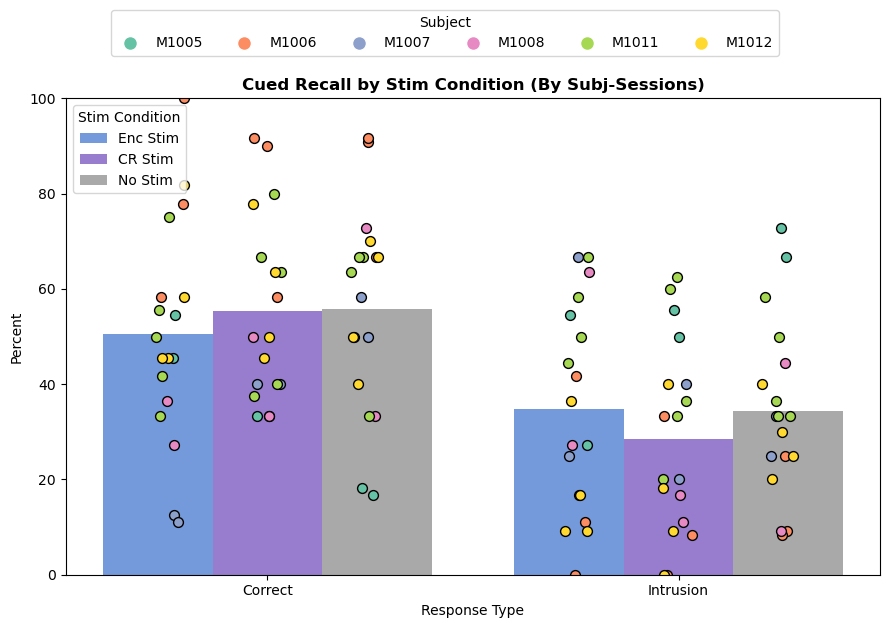

In [18]:
fig, ax = plt.subplots(figsize=(9, 6))

# Define color palettes
stim_palette = {"Enc Stim": "cornflowerblue", "CR Stim": "mediumpurple", "No Stim": "darkgray"}
subjects = df_subj_cleaned["subject"].unique()
subject_palette = {subj: color for subj, color in zip(subj_list, sns.color_palette("Set2", len(subj_list)))}

# === BARPLOT ===
sns.barplot(
    data=grouped_df,
    x="Response_Type",
    y="Percent",
    hue="Stim_Condition",
    palette=stim_palette,
    hue_order=["Enc Stim", "CR Stim", "No Stim"],
    ci=None,
    ax=ax
)

# === SCATTER OVERLAY OF ALL SESSIONS FROM ALL SUBJECTS ===
x_positions = {cat.get_text(): cat.get_position()[0] for cat in ax.get_xticklabels()}
offsets = {"Enc Stim": -0.24, "CR Stim": 0, "No Stim": 0.24}

for _, row in df_subj_cleaned.iterrows():
    x_pos = x_positions[row["Response_Type"]] + offsets[row["Stim_Condition"]] + np.random.uniform(-0.04, 0.04)
    ax.scatter(x=x_pos, y=row["Percent"], color=subject_palette[row["subject"]], edgecolor="black", s=50)

# === LABELS & LEGENDS ===
ax.set_title("Cued Recall by Stim Condition (By Subj-Sessions)", fontweight='bold')
ax.set_ylabel("Percent")
ax.set_xlabel("Response Type")
ax.set_ylim(0, 100)

# Stim condition legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, title="Stim Condition", loc="upper left")

# Session color legend above the plot
subject_legend = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=subject_palette[subj], markersize=10,
                              label=subj)
                  for subj in subject_palette]
fig.legend(handles=subject_legend, title="Subject", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=len(subject_palette))


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/tmp/ipykernel_93897/2892470778.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


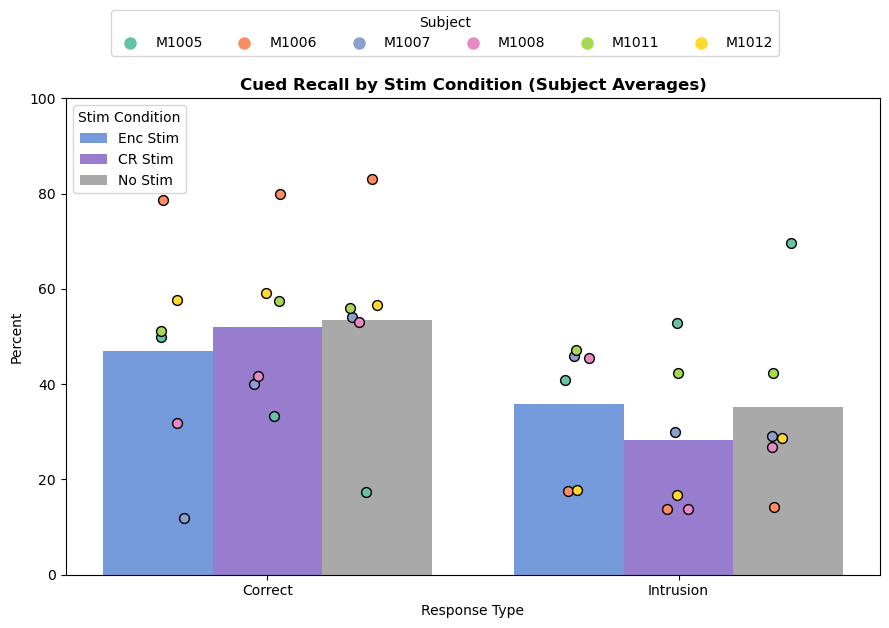

In [19]:
fig, ax = plt.subplots(figsize=(9, 6))

# Define color palettes
stim_palette = {"Enc Stim": "cornflowerblue", "CR Stim": "mediumpurple", "No Stim": "darkgray"}
subjects = df_subj_cleaned["subject"].unique()
subject_palette = {subj: color for subj, color in zip(subj_list, sns.color_palette("Set2", len(subj_list)))}

# === BARPLOT ===
sns.barplot(
    data=df_participant,
    x="Response Type",
    y="Percent",
    hue="Stim Condition",
    palette=stim_palette,
    hue_order=["Enc Stim", "CR Stim", "No Stim"],
    ci=None,
    ax=ax
)

# === SCATTER OVERLAY OF SUBJECTS ===
x_positions = {cat.get_text(): cat.get_position()[0] for cat in ax.get_xticklabels()}
offsets = {"Enc Stim": -0.24, "CR Stim": 0, "No Stim": 0.24}

for _, row in df_participant.iterrows():
    x_pos = x_positions[row["Response Type"]] + offsets[row["Stim Condition"]] + np.random.uniform(-0.04, 0.04)
    ax.scatter(x=x_pos, y=row["Percent"], color=subject_palette[row["subject"]], edgecolor="black", s=50)

# === LABELS & LEGENDS ===
ax.set_title("Cued Recall by Stim Condition (Subject Averages)", fontweight='bold')
ax.set_ylabel("Percent")
ax.set_xlabel("Response Type")
ax.set_ylim(0, 100)

# Stim condition legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, title="Stim Condition", loc="upper left")

# Session color legend above the plot
subject_legend = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=subject_palette[subj], markersize=10,
                              label=subj)
                  for subj in subject_palette]
fig.legend(handles=subject_legend, title="Subject", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=len(subject_palette))


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/tmp/ipykernel_93897/1786866302.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


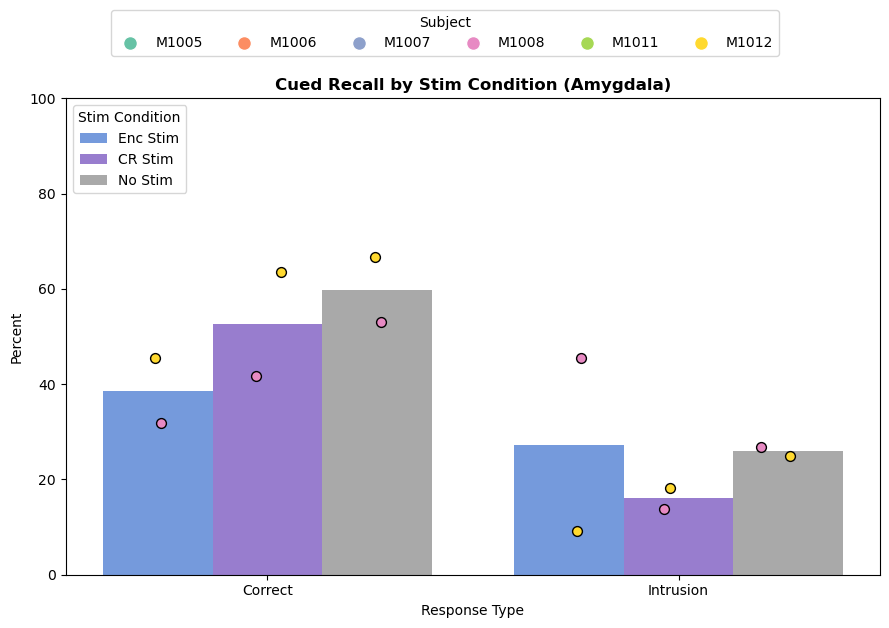

/tmp/ipykernel_93897/1786866302.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


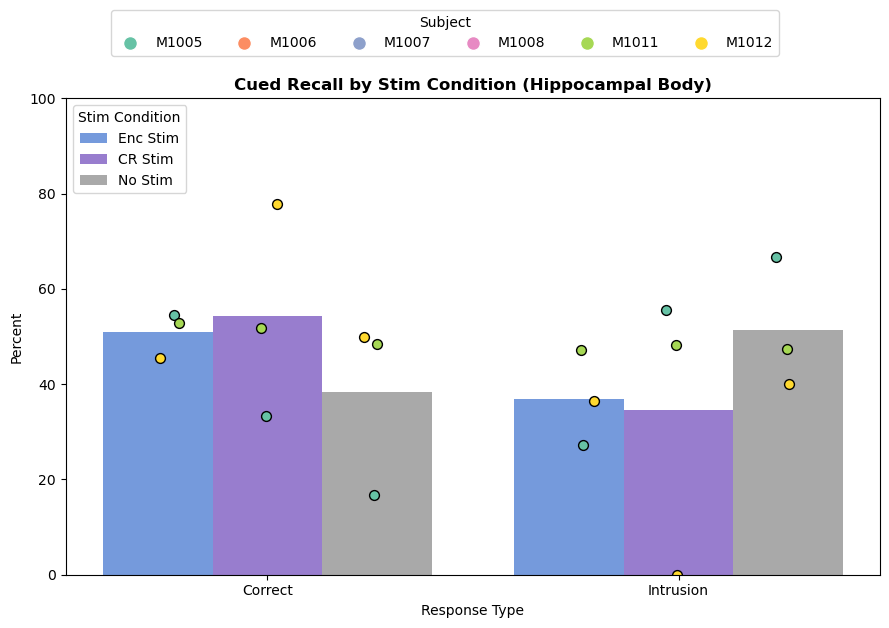

/tmp/ipykernel_93897/1786866302.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


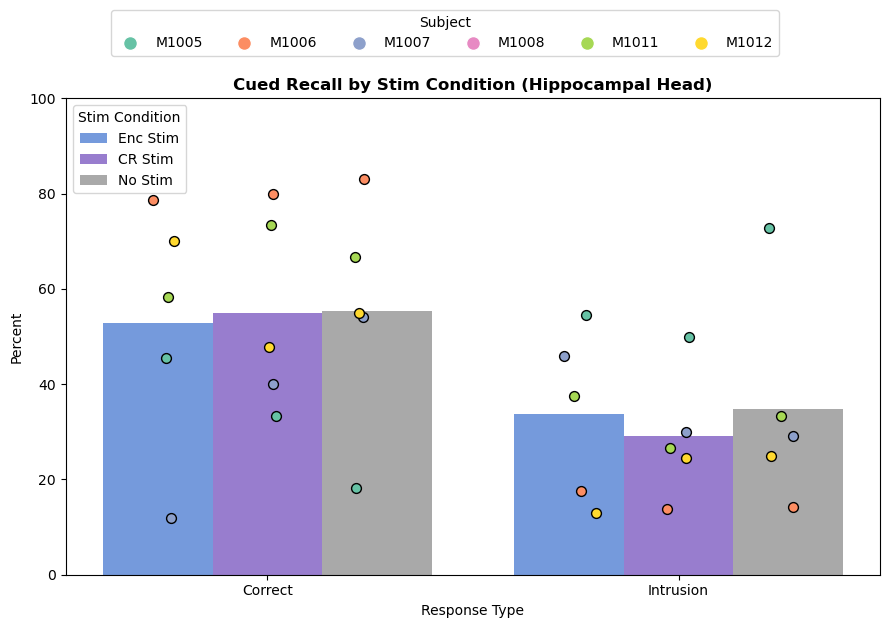

/tmp/ipykernel_93897/1786866302.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


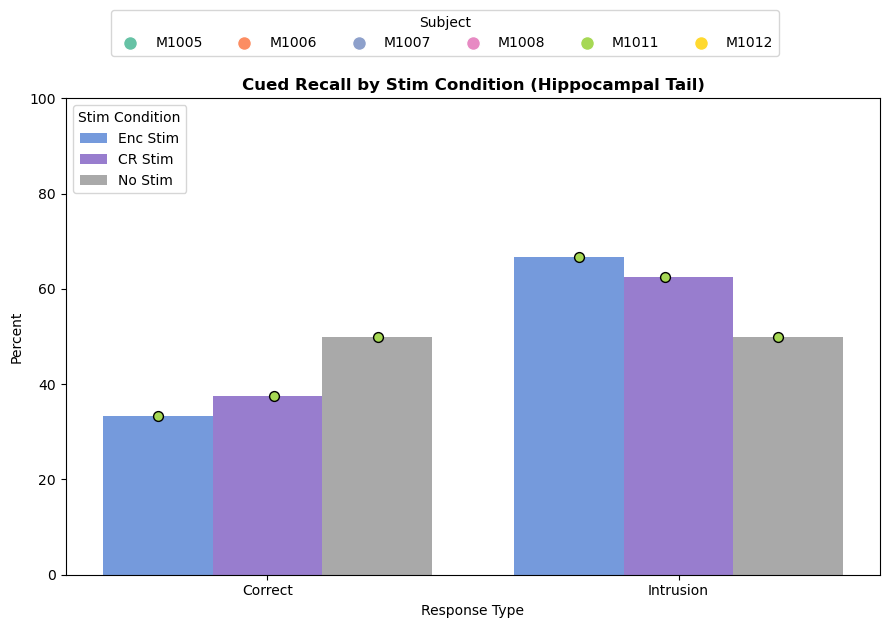

In [20]:
subj_list = df_subj_cleaned["subject"].unique()
subject_palette = {subj: color for subj, color in zip(subj_list, sns.color_palette("Set2", len(subj_list)))}
stim_palette = {"Enc Stim": "cornflowerblue", "CR Stim": "mediumpurple", "No Stim": "darkgray"}
offsets = {"Enc Stim": -0.24, "CR Stim": 0, "No Stim": 0.24}

# Loop through each region-specific df
for region_name, region_df in region_dfs.items():
    region_label = region_df["Stim_Region"].iloc[0].replace("_", " ").title()

    # Grouped mean for barplot
    grouped_region_df = (
        region_df
        .groupby(["Response Type", "Stim Condition"], as_index=False)
        .agg({"Percent": "mean"})
    )

    # Plot
    fig, ax = plt.subplots(figsize=(9, 6))

    # Barplot
    sns.barplot(
        data=grouped_region_df,
        x="Response Type",
        y="Percent",
        hue="Stim Condition",
        palette=stim_palette,
        hue_order=["Enc Stim", "CR Stim", "No Stim"],
        ci=None,
        ax=ax
    )

    # Scatter per subject
    x_positions = {cat.get_text(): cat.get_position()[0] for cat in ax.get_xticklabels()}

    for _, row in region_df.iterrows():
        x_pos = x_positions[row["Response Type"]] + offsets[row["Stim Condition"]] + np.random.uniform(-0.04, 0.04)
        ax.scatter(x=x_pos, y=row["Percent"], color=subject_palette[row["subject"]], edgecolor="black", s=50)

    # Title and axes
    ax.set_title(f"Cued Recall by Stim Condition ({region_label})", fontweight='bold')
    ax.set_ylabel("Percent")
    ax.set_xlabel("Response Type")
    ax.set_ylim(0, 100)

    # Legend: Stim Condition
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, title="Stim Condition", loc="upper left")

    # Legend: Subject colors above the plot
    subject_legend = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=subject_palette[subj], markersize=10,
                                 label=subj)
                      for subj in subject_palette]
    fig.legend(handles=subject_legend, title="Subject", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=len(subject_palette))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


two models:
    1. predicting recalls
    2. predicting intrusions
    
for each, stim condition is a categorical variable. this is the most simple model.

then, looking more complexly at other factors:
- baseline memory performance of an individual (using a score from neuropsycb reports)
- task type (cued recall vs. recognition) * later, we can separate into different models


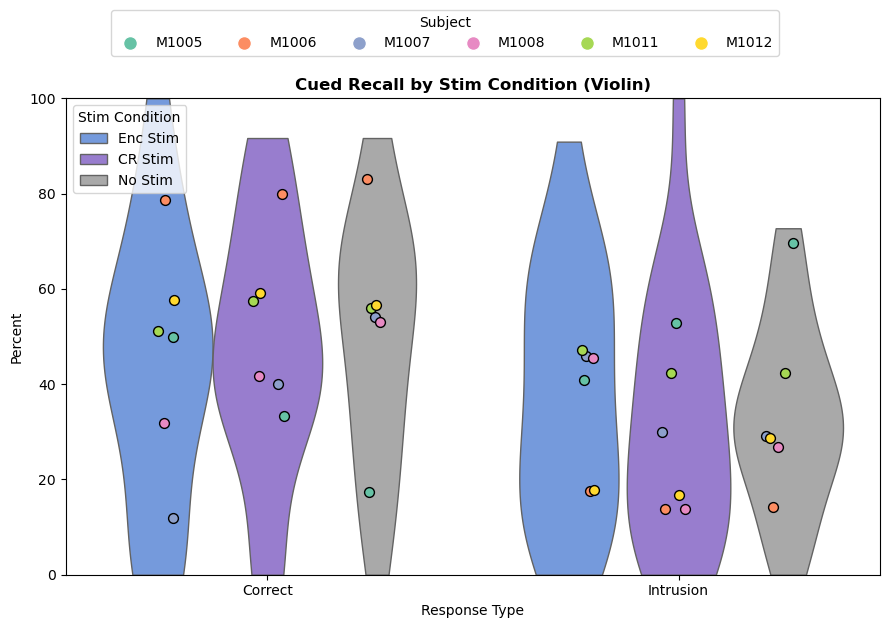

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Color setup ===
stim_palette = {"Enc Stim": "cornflowerblue", "CR Stim": "mediumpurple", "No Stim": "darkgray"}
subjects = df_subj["subject"].unique()
subject_palette = {subj: color for subj, color in zip(subjects, sns.color_palette("Set2", len(subjects)))}

# === Plot ===
fig, ax = plt.subplots(figsize=(9, 6))

# Violin plot
sns.violinplot(
    data=df_subj,
    x="Response Type",
    y="Percent",
    hue="Stim Condition",
    palette=stim_palette,
    hue_order=["Enc Stim", "CR Stim", "No Stim"],
    cut=0,
    inner=None,
    linewidth=1,
    ax=ax
)

# Scatter points (subject-level)
x_positions = {cat.get_text(): cat.get_position()[0] for cat in ax.get_xticklabels()}
offsets = {"Enc Stim": -0.24, "CR Stim": 0, "No Stim": 0.24}

for _, row in df_participant.iterrows():
    x_pos = x_positions[row["Response Type"]] + offsets[row["Stim Condition"]] + np.random.uniform(-0.04, 0.04)
    ax.scatter(x=x_pos, y=row["Percent"], color=subject_palette[row["subject"]], edgecolor="black", s=50)

# === Labels and titles ===
ax.set_title("Cued Recall by Stim Condition (Violin)", fontweight='bold')
ax.set_ylabel("Percent")
ax.set_xlabel("Response Type")
ax.set_ylim(0, 100)

# Stim Condition legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, title="Stim Condition", loc="upper left")

# Subject legend
subject_legend = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=subject_palette[subj], markersize=10,
                              label=subj)
                  for subj in subject_palette]
fig.legend(handles=subject_legend, title="Subject", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=len(subject_palette))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


[0, 1, 2, 3, 4]
Experiment: MemMapOpenLoop, Session: 0, Stim Mode: open, Subject: M1004
Electrodes: LB1_LB2
Experiment: MemMapOpenLoop, Session: 1, Stim Mode: open, Subject: M1004
Electrodes: LB2_LB3
Experiment: MemMapOpenLoop, Session: 2, Stim Mode: open, Subject: M1004
Electrodes: LB3_LB4
Experiment: MemMapOpenLoop, Session: 3, Stim Mode: open, Subject: M1004
Electrodes: LC3_LC4
Experiment: MemMapOpenLoop, Session: 4, Stim Mode: open, Subject: M1004
Electrodes: LD1_LD2
session 0:
PRACTICE FOUND
session 1:
PRACTICE FOUND
session 2:
session 3:
session 4:


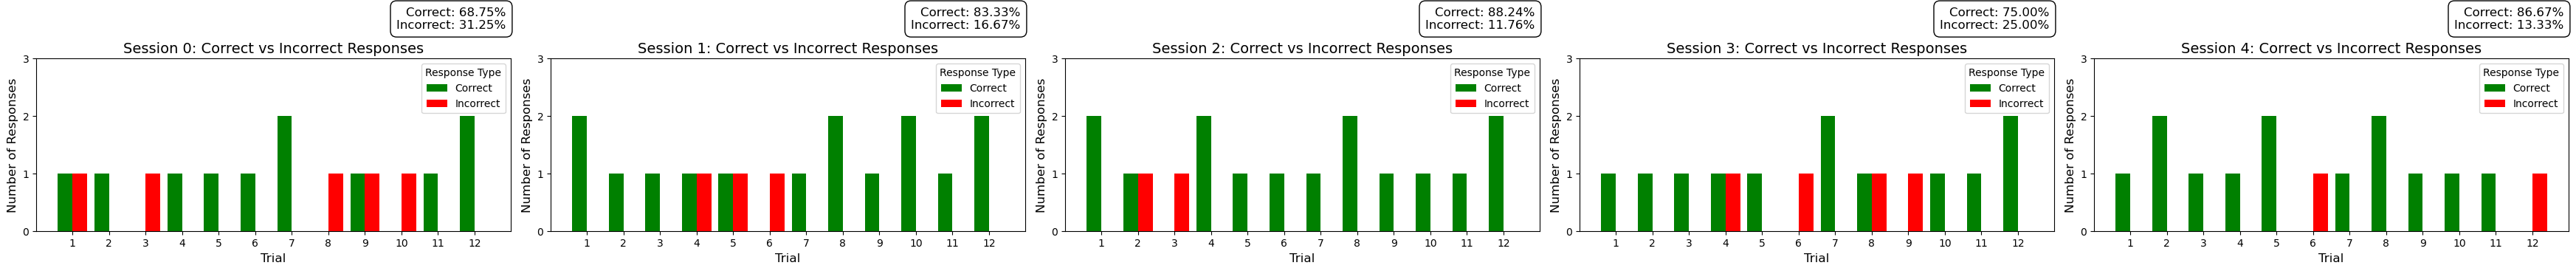

Session: 0
Session: 1
Session: 2
Session: 3
Session: 4
Cued Recall: Results Table
results           NaN  correct  intrusion  total
session stimCond                                
0       False      24        0          0     24
        True       12        0          0     12
1       False       7        2         15     24
        True        2        0         10     12
2       False       1        7         16     24
        True        2        4          6     12
3       False       4        8         12     24
        True        1        3          8     12
4       False       7        1         16     24
        True        4        1          7     12
[0, 1, 2]
Experiment: MemMapOpenLoop, Session: 0, Stim Mode: open, Subject: M1005
Electrodes: LA1_LA2
Experiment: MemMapOpenLoop, Session: 1, Stim Mode: open, Subject: M1005
Electrodes: LA2_LA3
Experiment: MemMapOpenLoop, Session: 2, Stim Mode: open, Subject: M1005
Electrodes: LA3_LA4
session 0:
PRACTICE FOUND
session 1:
PRACTIC

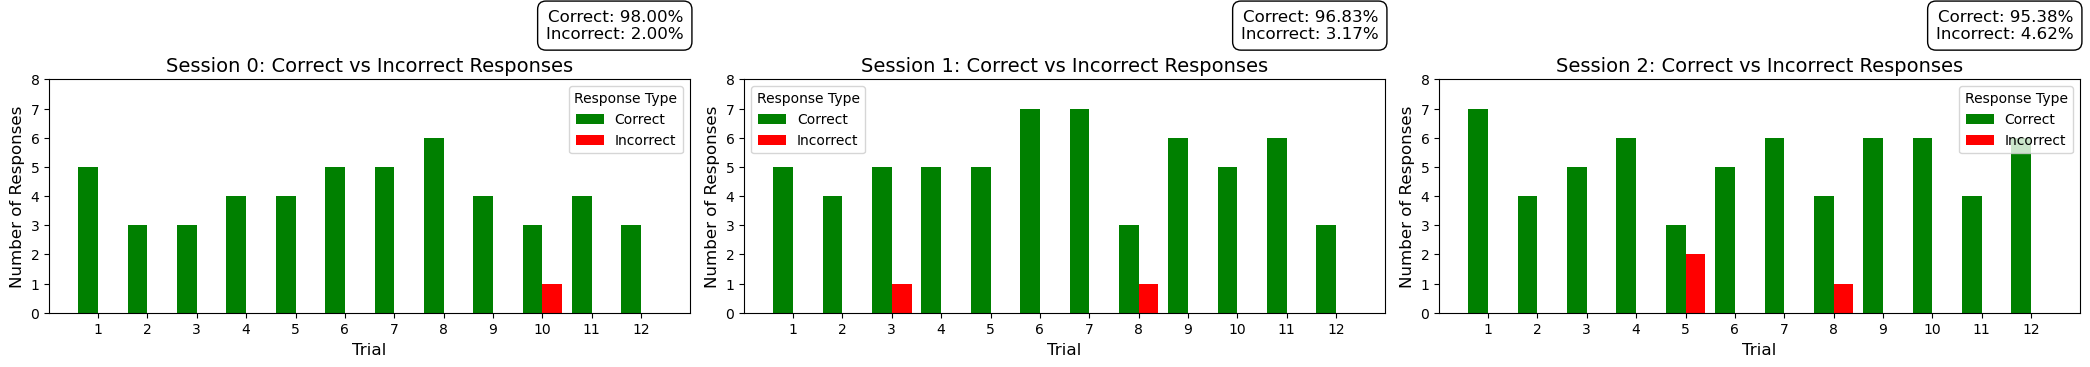

Session: 0
Session: 1
Session: 2
Cued Recall: Results Table
results           NaN  correct  intrusion  total
session stimCond                                
0       False       1       15          8     24
        True        1        7          4     12
1       False       2       17          5     24
        True        1        9          2     12
2       False       0       23          1     24
        True        0       11          1     12
[0, 1]
Experiment: MemMapOpenLoop, Session: 0, Stim Mode: open, Subject: M1007
Electrodes: LB1_LB2
Experiment: MemMapOpenLoop, Session: 1, Stim Mode: open, Subject: M1007
Electrodes: LB2_LB3
session 0:
PRACTICE FOUND
session 1:
PRACTICE FOUND


FileNotFoundError: [Errno 2] No such file or directory: '/home1/jacquelinekim/MemMap_Analyses/test/M1007/TrialLevelMD.pdf'

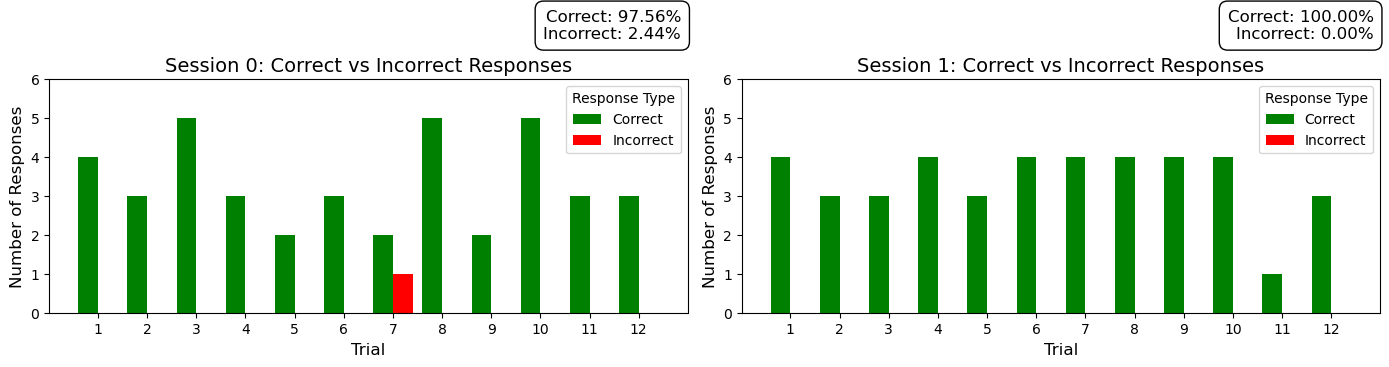

In [22]:
# create a column that notes subject. concatenate dataframes.
# third bar for encoding stimulation in CR and Recog stim plots.
# get the script working for all subjects at once.
# get annotations.
# courier subjects' annotations. contact daniella about which need to be annotated.


for subj in subj_list:
    # Define and filter session folders
    directory_path = '/home1/jacquelinekim/MemMap_Analyses/' + str(subj) + '/'
    folder_names = os.listdir(directory_path)
    sessions = [int(folder.split('_')[1]) for folder in folder_names if folder.startswith('session_')]
    # Sort and print
    sessions.sort()
    print(sessions)
    
    extract_stim_sites(sessions, directory_path) # Find stim sites using function
    
    dataframes = [[] for _ in range(len(sessions))] #setting up the dataframe structure by session. noting which sessions have practice sessions.
    raw_log = {}
    for sess in sessions:
        print('session ' + str(sess) + ':')
        path = f'/home1/jacquelinekim/MemMap_Analyses/{subj}/session_{sess}/elemem/event.log'
        raw_log[sess] = pd.read_json(path, lines=True)
        dataframes[sess] = get_rows_between_trials(raw_log[sess]) # Apply the function
        
    analyze_math_distractor(dataframes, subj) # Math plots using function
    
    cr_df, stim_summary = process_cued_recall_data(dataframes, sessions, subj) # Process cued recall
    
    # plot_cued_recall_performance(cr_df, sessions, subj, stim_summary2, stimSitesBySession) # Plot cued recall
    

In [ ]:
subj = 'M1005'

In [ ]:
eeg_df = [[] for _ in range(len(sessions))]
raw_data = [[] for _ in range(len(sessions))]

for i in sessions:
    print('EEG DATA FILE FOR SESSION ' + str(i) + ':')
    path = '/home1/jacquelinekim/MemMap_Analyses/' + str(subj) + '/session_' + str(i) + '/elemem/eeg_data.edf'
    eeg_df[i] = mne.io.read_raw_edf(path)
    print(eeg_df[i].info)
    print(eeg_df[i].ch_names)
    raw_data[i] = eeg_df[i].get_data()
    print('RAW DATA FOR SESSION ' + str(i) + ':')
    print(raw_data[i])

In [ ]:
for session in sessions:
    print(raw_data[session].shape)

    print(sys.getsizeof(raw_data[session]))

In [ ]:
print(raw_data[0])

In [ ]:
# trial_data[0]['stim']
# trial_data[0]['stimList']['encodingStim']


In [ ]:
stimInfo = [[] for _ in range(len(sessions))]
temp = []

for session in range(len(sessions)):
    for trial in range(len(dataframes[session])):
        # Extract the 'data' field for trials where the 'type' is 'TRIAL'
        trial_data = dataframes[session][trial][0][dataframes[session][trial][0]['type'] == 'TRIAL']['data'].iloc[0]
        if trial_data['stim'] == False:
            temp = 'nonStim'
        else:
            temp = trial_data['stimList']
        stimInfo[session].append(temp)

In [ ]:
stimInfo[session]

In [ ]:
stimInfo[session][10]

In [ ]:
encodingStimTrials = [[] for _ in range(len(sessions))]
recallStimTrials = [[] for _ in range(len(sessions))]
recogStimTrials = [[] for _ in range(len(sessions))]

for session in sessions:
    for trial in list(range(len(dataframes[session]))):
        if stimInfo[session][trial] != 'nonStim':
            if stimInfo[session][trial]['encodingStim'] == True:
                encodingStimTrials[session].append(trial)
            if stimInfo[session][trial]['recallStim'] == True:
                recallStimTrials[session].append(trial)
            if stimInfo[session][trial]['recogStim'] == True:
                recogStimTrials[session].append(trial)

print('encoding stim trials: ' + str(encodingStimTrials))
print('cued-recall stim trials: ' + str(recallStimTrials))
print('recog stim trials: ' + str(recogStimTrials))


In [ ]:
trial

In [ ]:
stim_encoding_df = [[] for _ in range(len(sessions))]

for session in sessions:
    for trial in encodingStimTrials[session]:
        stim_encoding_df[session] = dataframes[session][trial][0][dataframes[session][trial][0]['type'].isin(['STIM', 'STIMMING', 'WORD', 'frameDisplayed'])]

In [ ]:
stim_encoding_df[0]

In [ ]:
pd.set_option('display.max_rows', None)
dataframes[0][2][0]

In [ ]:
for session in sessions:
    print('SESSION ' + str(session) + ':')
    eegstart = raw_log[i].loc[raw_log[session]['type'] == 'EEGSTART', 'time'].iloc[0]
    heartbeat = raw_log[session].loc[raw_log[session]['type'] == 'HEARTBEAT', 'time'].iloc[0]
    word = raw_log[session].loc[raw_log[session]['type'] == 'WORD', 'time'].iloc[0]
    difference = word - eegstart 

    print(eegstart) # EEGSTART is when EEG starts to be collected/recorded. We have to subtract the time here from further points.
    print(heartbeat) #First heartbeat
    print('difference = (first word)-(eegstart) = ' + str(difference))

In [ ]:
dataframes[session][trial][0]

In [ ]:
raw_data[session][0][int(difference)] # EEG at the time of the first word?

In [ ]:
# first dimension will be channels, second dimension is samples (or timepoints)
for session in sessions:
    word_eeg = raw_data[session][:, int(difference)-1000:int(difference)+1000] # EEG 1 second before and after first word onset
    time_eeg = range(-1000,1000)
    print(word_eeg.shape)

In [ ]:
num_channels = word_eeg.shape[0]
num_columns = 10  # Adjust the number of columns per row
num_rows = int(np.ceil(num_channels / num_columns))  # Calculate required rows

# Create subplots with the specified grid
fig, axes = plt.subplots(num_rows, num_columns, figsize=(30, 3 * num_rows))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot each channel's EEG data
for channel_idx in range(num_channels):
    channel_names = eeg_df[session].ch_names
    ax = axes[channel_idx]
    
    # Plot the EEG signal for the current channel
    ax.plot(time_eeg, word_eeg[channel_idx], label=f"{channel_names[channel_idx]}", color='grey')
    
    # Customize the plot
    ax.set_xlabel('Time From Word Onset (ms)', fontsize=7)
    ax.set_ylabel('EEG Signal', fontsize=7)
    ax.axvline(x=0, color='black', linewidth=1)  # Add a vertical line at time = 0
    ax.set_title(f"{channel_names[channel_idx]}", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    # Optional: Remove y-axis labels on the rightmost plots
    if (channel_idx + 1) % num_columns == 0:
        ax.set_ylabel('')


for empty_ax in axes[num_channels:]: # Hide any remaining unused axes
    empty_ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import mne

# For example purposes, we assume 'sessions' is defined

eeg_df = [[] for _ in range(len(sessions))]
raw_data = [[] for _ in range(len(sessions))]

# Read data for each session
for session in sessions:
    print('EEG DATA FILE FOR SESSION ' + str(session) + ':')
    path = '/home1/jacquelinekim/MemMap_Analyses/' + str(subj) + '/session_' + str(session) + '/elemem/eeg_data.edf'
    eeg_df[session] = mne.io.read_raw_edf(path)
    print(eeg_df[session].info)
    print(eeg_df[session].ch_names)
    raw_data[session] = eeg_df[session].get_data()
    print('RAW DATA FOR SESSION ' + str(session) + ':')
    print(raw_data[session])

In [ ]:
# Plot EEG data for each session
for session in sessions:
    print('SESSION ' + str(session) + ':')
    eegstart = raw_log[session].loc[raw_log[session]['type'] == 'EEGSTART', 'time'].iloc[0]
    heartbeat = raw_log[session].loc[raw_log[session]['type'] == 'HEARTBEAT', 'time'].iloc[0]
    word = raw_log[session].loc[raw_log[session]['type'] == 'WORD', 'time'].iloc[0]
    difference = word - eegstart
    
    print(eegstart) # EEGSTART
    print(heartbeat) # First heartbeat
    print('difference = (first word)-(eegstart) = ' + str(difference))

    # Define time axis based on EEG data
    time_eeg = np.arange(raw_data[session].shape[1]) / eeg_df[session].info['sfreq']
    
    # Plot EEG signals
    num_channels = raw_data[session].shape[0]
    num_columns = 10
    num_rows = int(np.ceil(num_channels / num_columns))

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(30, 3 * num_rows))
    axes = axes.flatten()

    for channel_idx in range(num_channels):
        channel_names = eeg_df[session].ch_names
        ax = axes[channel_idx]
        
        ax.plot(time_eeg, raw_data[session][channel_idx], label=f"{channel_names[channel_idx]}", color='grey')
        ax.set_xlabel('Time From Word Onset (ms)', fontsize=7)
        ax.set_ylabel('EEG Signal', fontsize=7)
        ax.axvline(x=0, color='black', linewidth=1)
        ax.set_title(f"{channel_names[channel_idx]}", fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=7)

    for empty_ax in axes[num_channels:]:
        empty_ax.axis('off')

    plt.tight_layout()
    plt.show()


plot the data for each channel separately.
and then group based on name of the electrodes.

electrode = shank that has multiple channels


stimulation vs non-stimulation

overlaying what the stimulation looks like on non-stimulation trials.